# InitialDataAnalysis

Read in data and get into the correct format for MiniSom

Perform K-means to get an estimate of number of clusters

Code adapted from https://www.kaggle.com/code/kaushikmajumder/alllife-bank-credit-card-customer-segmentation/notebook

In [300]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score


### Load data file

Delete named columns

Save metabolote names for later

In [322]:
arr_data_pd = pd.read_csv("./Data/Arabidopsis-T87-timeseries-NaCl-by-metabolite-BioCyc-Master-SOM.csv", skiprows=1, header=None)
metabolites = arr_data_pd[0]
arr_data_pd=arr_data_pd.drop(arr_data_pd.columns[[0, 1]], axis=1)

In [323]:
arr_raw_data_pd = arr_data_pd.copy()
arr_raw_data_pd.head(5)


,2,3,4,5,6,7,8,9
0,1.19,1.32,0.86,0.68,0.54,1.84,3.23,3.63
1,0.87,1.26,0.98,0.67,0.53,4.94,3.67,12.75
2,1.31,1.45,1.18,1.22,0.52,0.59,0.31,0.26
3,1.61,0.72,0.68,1.91,1.42,3.30,0.90,1.40
4,0.75,1.08,0.80,0.55,0.39,0.21,0.87,1.62


### Scale data

In [324]:
scaler = StandardScaler()
#arr_data_pd_scaled = scaler.fit_transform(arr_data_pd.iloc[:,1:-1])
arr_data_pd_scaled = scaler.fit_transform(arr_data_pd)

print(arr_data_pd)
arr_data_pd_scaled[1:5]

       2     3     4     5     6     7     8      9
0   1.19  1.32  0.86  0.68  0.54  1.84  3.23   3.63
1   0.87  1.26  0.98  0.67  0.53  4.94  3.67  12.75
2   1.31  1.45  1.18  1.22  0.52  0.59  0.31   0.26
3   1.61  0.72  0.68  1.91  1.42  3.30  0.90   1.40
4   0.75  1.08  0.80  0.55  0.39  0.21  0.87   1.62
5   1.17  0.82  0.58  0.97  1.18  1.60  1.35   0.70
6   0.82  0.92  0.72  0.70  0.53  0.23  0.91   2.30
7   1.06  1.00  1.07  0.89  0.92  0.91  1.08   0.96
8   0.79  1.11  0.87  0.73  0.62  1.17  0.82   2.27
9   0.87  1.26  1.21  0.87  0.77  1.01  0.92   1.70
10  1.03  1.50  1.34  0.97  0.74  0.27  1.23   0.78
11  1.17  0.99  0.90  0.91  0.84  0.47  1.88   1.84
12  1.50  0.91  1.00  1.71  0.95  0.70  0.37   0.82
13  0.60  0.94  0.82  0.92  0.87  0.49  0.80   0.56
14  0.71  0.90  0.60  0.54  0.53  0.37  0.76   2.02
15  1.10  1.15  1.60  1.24  1.00  0.34  0.61   0.76
16  0.72  1.05  0.89  0.64  0.26  0.62  0.85   1.59
17  0.97  1.02  1.02  0.85  0.85  0.38  0.63   0.58
18  1.32  1.

array([[-0.46113611,  0.2005841 , -0.2703305 , -1.04334973, -1.15688276,
         4.83447359,  3.96742452,  4.74872322],
       [ 1.09670948,  0.56396784,  0.08377655,  0.94882101, -1.20288877,
        -0.3356911 , -1.09699729, -0.51816221],
       [ 2.15887694, -0.83219076, -0.80149108,  3.44808975,  2.93765186,
         2.88526208, -0.20770894, -0.03743768],
       [-0.88600309, -0.14367419, -0.58902685, -1.47800516, -1.80096686,
        -0.78733767, -0.25292699,  0.05533372]])

### Plot elbow curve

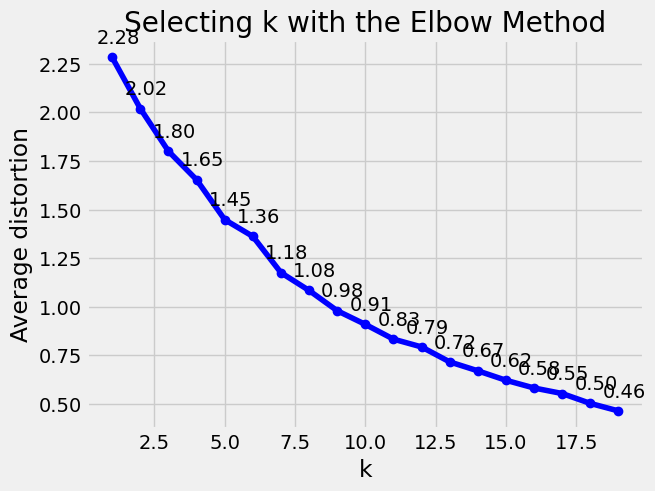

In [325]:
clusters = range(1, 20)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, n_init=25, max_iter = 600, random_state=0)
    model.fit(arr_data_pd_scaled)
    prediction = model.predict(arr_data_pd_scaled)
    distortion = (
        sum(
            np.min(cdist(arr_data_pd_scaled, model.cluster_centers_, "euclidean"), axis=1)
        )
        / arr_data_pd_scaled.shape[0]
    )

    meanDistortions.append(distortion)


plt.plot(clusters, meanDistortions, "bo-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
for x,y in zip(clusters, meanDistortions):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

No real elbow in curve ...

### Confirm with Silhouette Score

/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_in

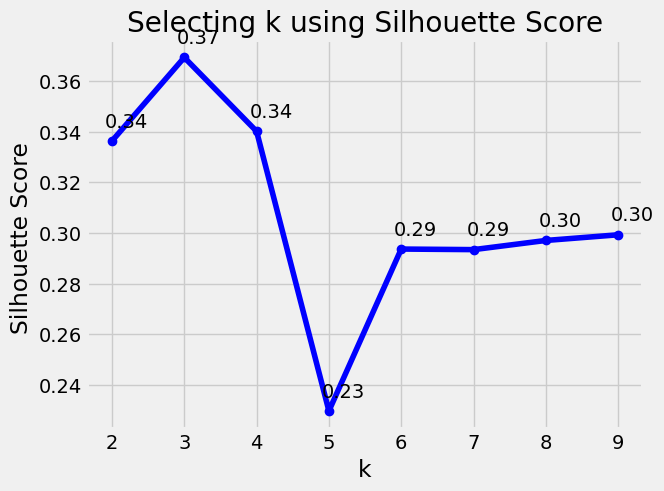

In [348]:
sil_score = []
cluster_list = list(range(2, 10))
for k in cluster_list:
    clusterer = KMeans(n_clusters=k, random_state=0)
    preds = clusterer.fit_predict(arr_data_pd_scaled)
    #centers = clusterer.cluster_centers_
    score = silhouette_score(arr_data_pd_scaled, preds, metric='euclidean')
    sil_score.append(score)

plt.plot(cluster_list, sil_score, "bo-")
plt.xlabel("k")
plt.ylabel("Silhouette Score ")
plt.title("Selecting k using Silhouette Score")
for x,y in zip(cluster_list, sil_score):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

Looks like 3 clusters, but not a good score ... preference is 0.6 or above

Hoever, does seem to be consistent with PCA

More detailed Silhouette analysis ...

In [338]:
print(arr_data_pd_scaled)
print(type(arr_data_pd_scaled))

[[ 6.71842503e-01  3.15336857e-01 -4.82794734e-01 -1.00712844e+00
  -1.11087675e+00  1.14998841e+00  3.30422643e+00  9.02926971e-01]
 [-4.61136114e-01  2.00584096e-01 -2.70330504e-01 -1.04334973e+00
  -1.15688276e+00  4.83447359e+00  3.96742452e+00  4.74872322e+00]
 [ 1.09670948e+00  5.63967841e-01  8.37765459e-02  9.48821007e-01
  -1.20288877e+00 -3.35691097e-01 -1.09699729e+00 -5.18162214e-01]
 [ 2.15887694e+00 -8.32190759e-01 -8.01491079e-01  3.44808975e+00
   2.93765186e+00  2.88526208e+00 -2.07708938e-01 -3.74376828e-02]
 [-8.86003095e-01 -1.43674189e-01 -5.89026849e-01 -1.47800516e+00
  -1.80096686e+00 -7.87337668e-01 -2.52926989e-01  5.53337180e-02]
 [ 6.01031339e-01 -6.40936157e-01 -9.78544604e-01  4.32888541e-02
   1.83350769e+00  8.64737946e-01  4.70561841e-01 -3.32619413e-01]
 [-6.38164022e-01 -4.49681554e-01 -7.30669669e-01 -9.34685871e-01
  -1.15688276e+00 -7.63566795e-01 -1.92636254e-01  3.42081684e-01]
 [ 2.11569940e-01 -2.96677872e-01 -1.10982331e-01 -2.46481435e-01
   

Below code from https://gist.githubusercontent.com/satkr7/2a45e3d4af279458b48eba32add0d17e/raw/e9d6796a57098bd29ded167238b6c1f7e9463ce1/silhouette_method.py

[[ 1.19  1.32  0.86  0.68  0.54  1.84  3.23  3.63]
 [ 0.87  1.26  0.98  0.67  0.53  4.94  3.67 12.75]
 [ 1.31  1.45  1.18  1.22  0.52  0.59  0.31  0.26]
 [ 1.61  0.72  0.68  1.91  1.42  3.3   0.9   1.4 ]
 [ 0.75  1.08  0.8   0.55  0.39  0.21  0.87  1.62]
 [ 1.17  0.82  0.58  0.97  1.18  1.6   1.35  0.7 ]
 [ 0.82  0.92  0.72  0.7   0.53  0.23  0.91  2.3 ]
 [ 1.06  1.    1.07  0.89  0.92  0.91  1.08  0.96]
 [ 0.79  1.11  0.87  0.73  0.62  1.17  0.82  2.27]
 [ 0.87  1.26  1.21  0.87  0.77  1.01  0.92  1.7 ]
 [ 1.03  1.5   1.34  0.97  0.74  0.27  1.23  0.78]
 [ 1.17  0.99  0.9   0.91  0.84  0.47  1.88  1.84]
 [ 1.5   0.91  1.    1.71  0.95  0.7   0.37  0.82]
 [ 0.6   0.94  0.82  0.92  0.87  0.49  0.8   0.56]
 [ 0.71  0.9   0.6   0.54  0.53  0.37  0.76  2.02]
 [ 1.1   1.15  1.6   1.24  1.    0.34  0.61  0.76]
 [ 0.72  1.05  0.89  0.64  0.26  0.62  0.85  1.59]
 [ 0.97  1.02  1.02  0.85  0.85  0.38  0.63  0.58]
 [ 1.32  1.74  1.85  1.28  0.7   0.26  0.97  0.25]
 [ 1.81  3.71  3.64  1.25  0.76

/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_in

For n_clusters = 6 The average silhouette_score is : 0.29361669329089296


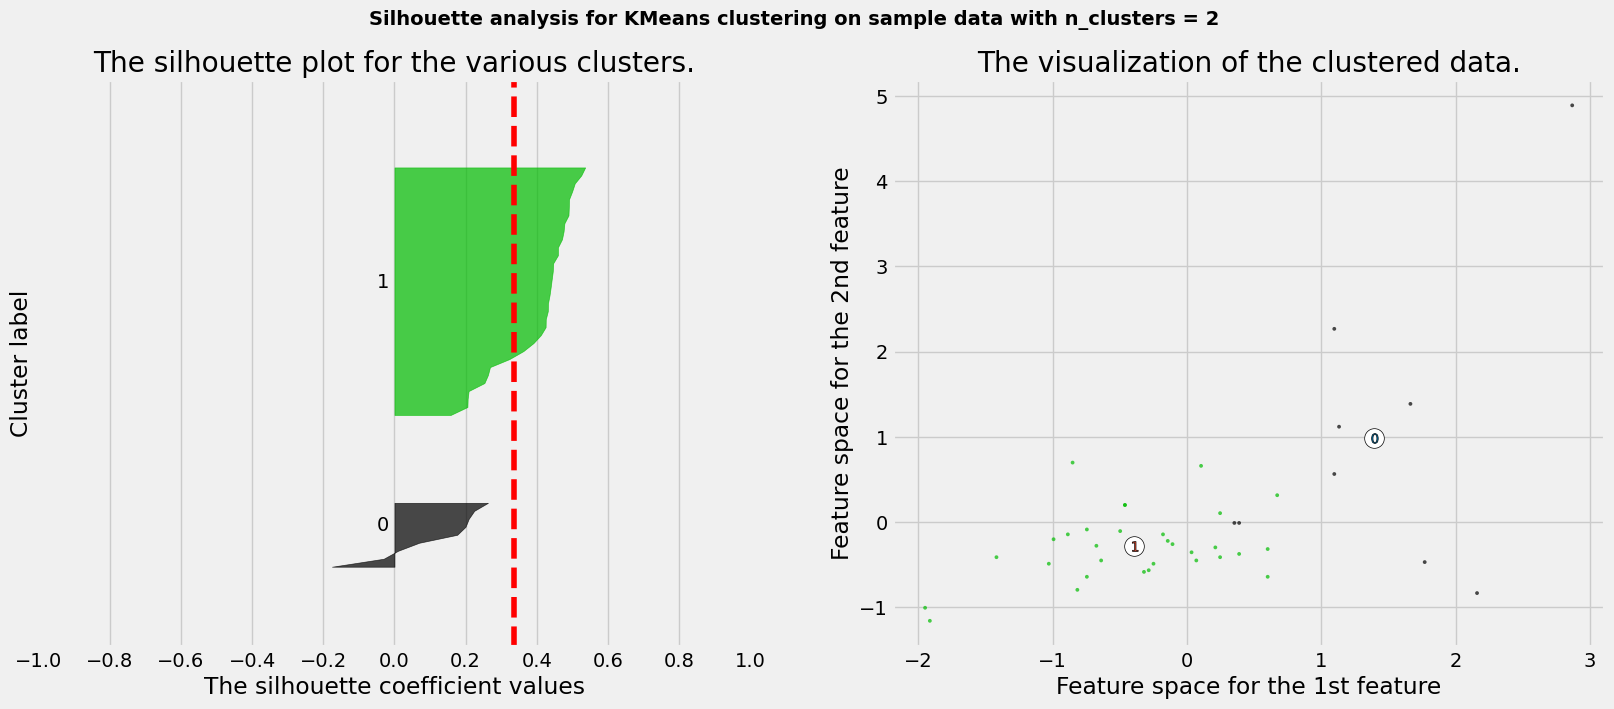

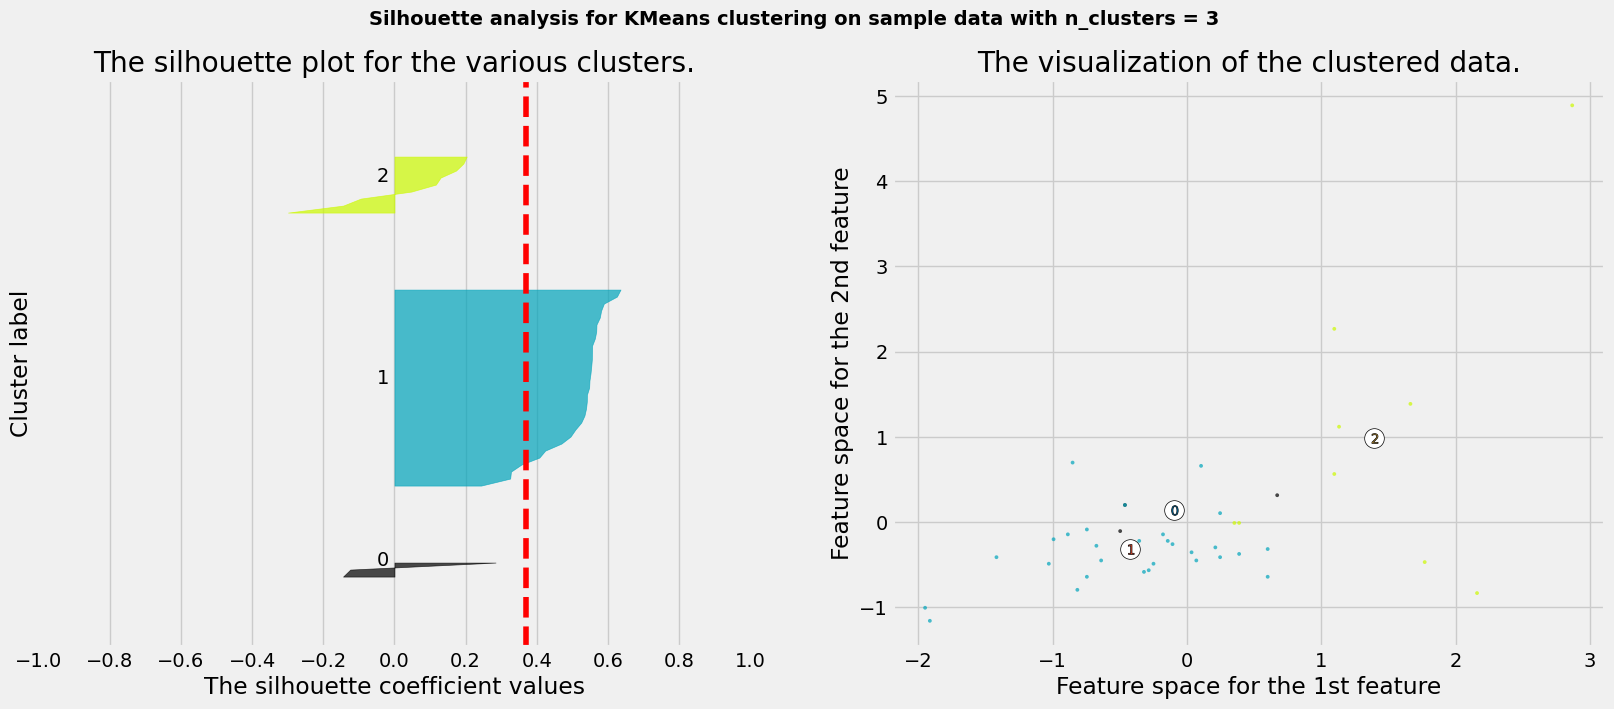

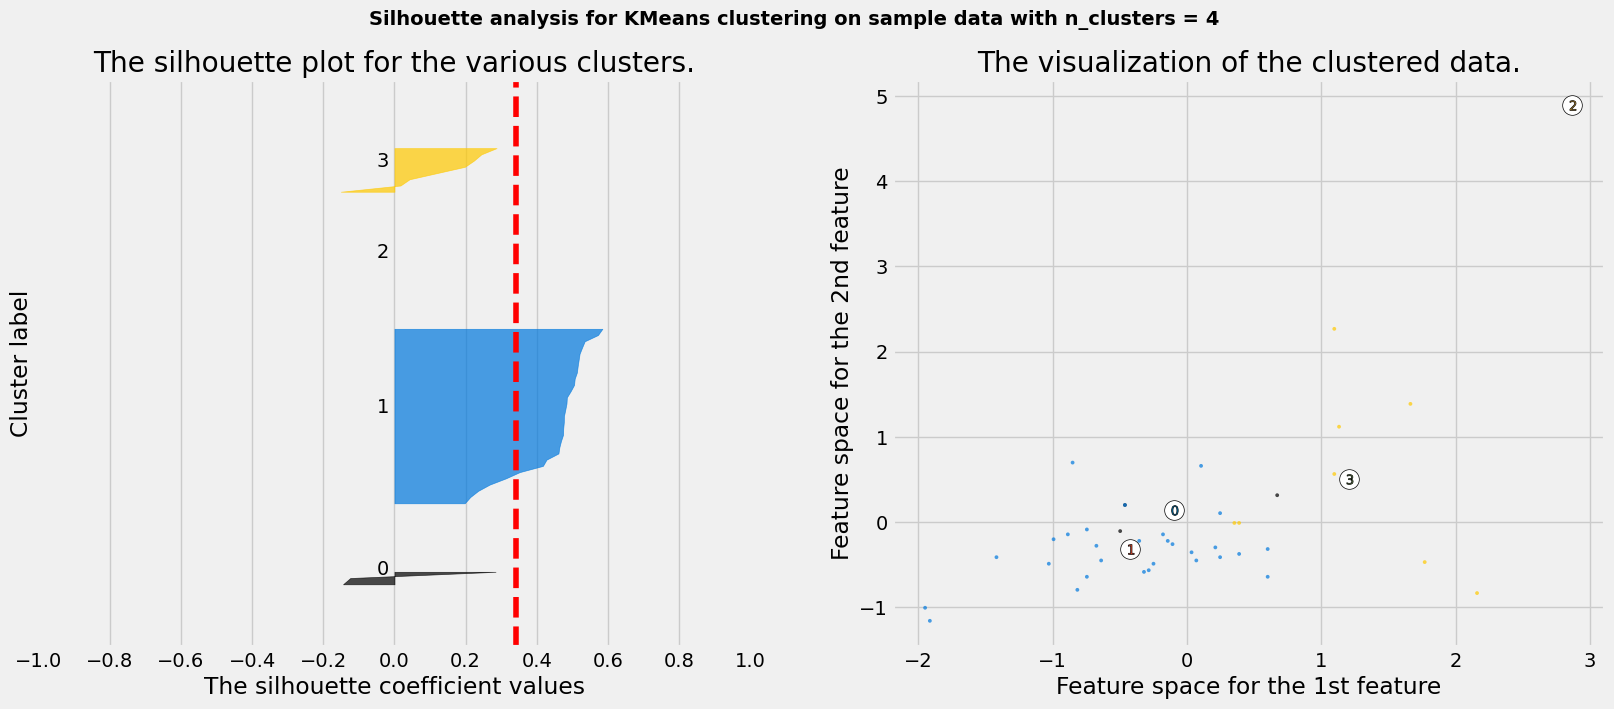

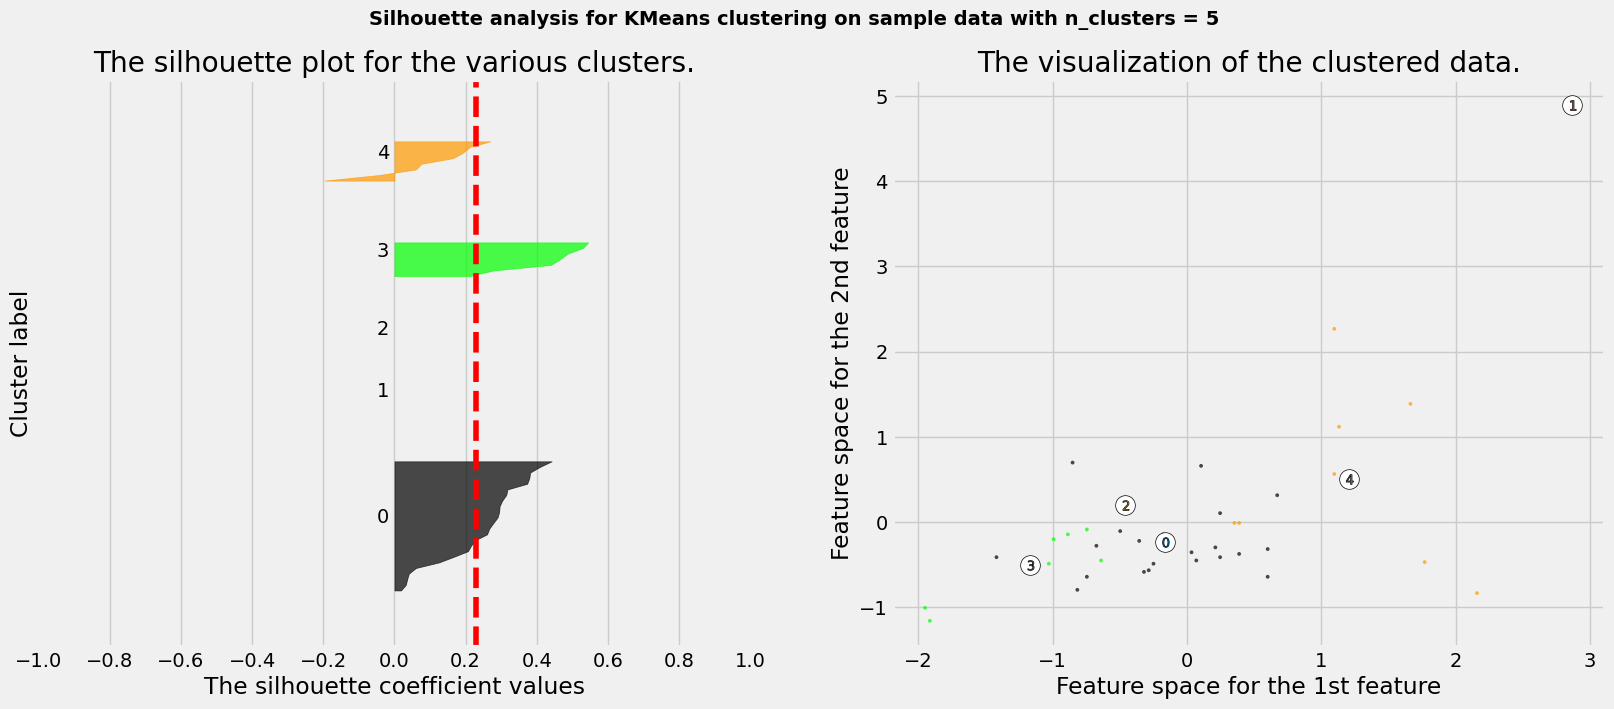

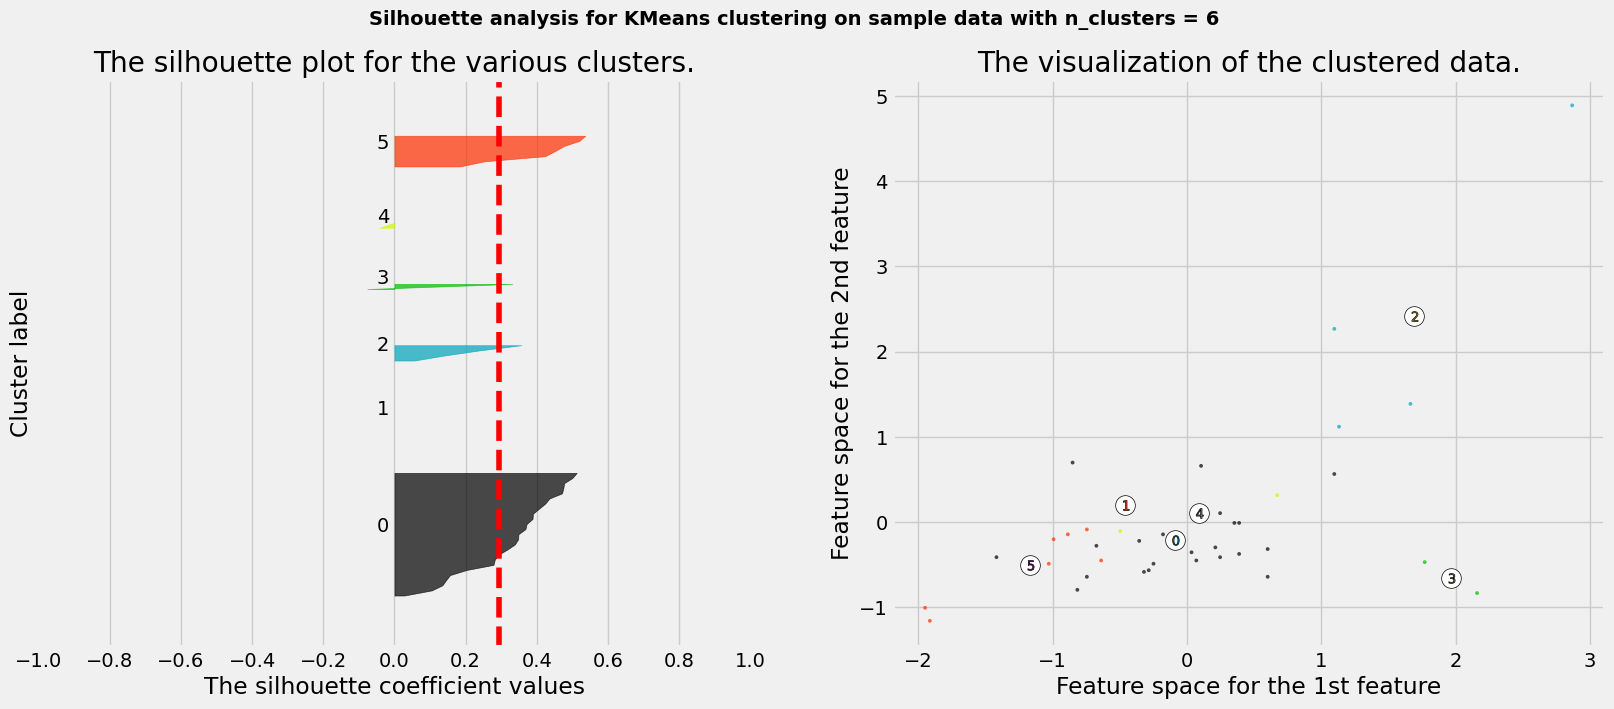

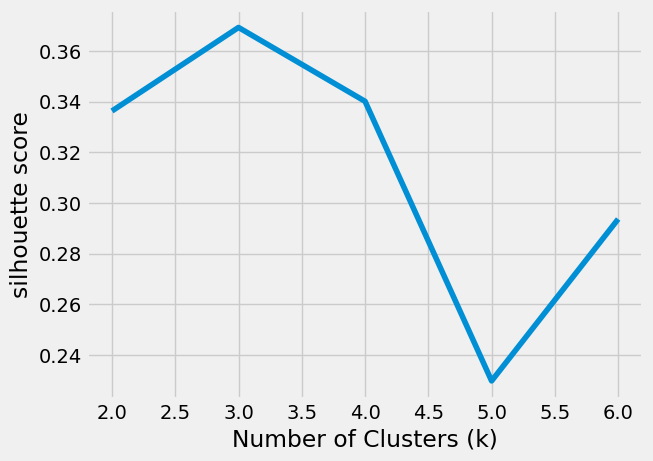

In [350]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

scaler = StandardScaler()
sil_data = arr_data_pd.to_numpy()
sil_data_scaled = scaler.fit_transform(sil_data)


print(sil_data)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(sil_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(sil_data_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(sil_data_scaled, cluster_labels, metric='euclidean')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sil_data_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(sil_data_scaled[:, 0], sil_data_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

Confirm with Davies-Bouldin ...

/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_in

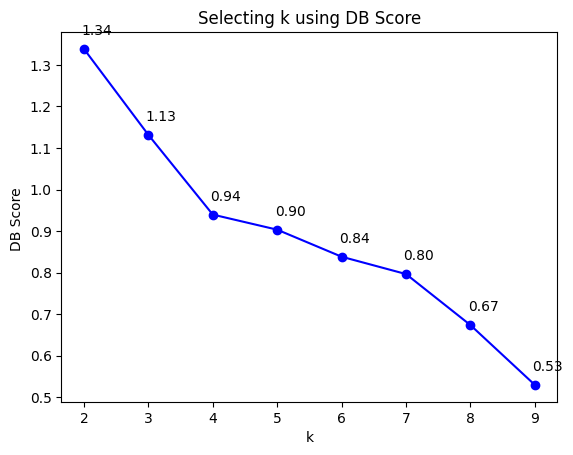

In [269]:
db_score = []
cluster_list = list(range(2, 10))
for k in cluster_list:
    clusterer = KMeans(n_clusters=k, random_state=0)
    preds = clusterer.fit_predict(arr_data_pd_scaled)
    #centers = clusterer.cluster_centers_
    score = davies_bouldin_score(arr_data_pd_scaled, preds)
    db_score.append(score)

plt.plot(cluster_list, db_score, "bo-")
plt.xlabel("k")
plt.ylabel("DB Score ")
plt.title("Selecting k using DB Score")
for x,y in zip(cluster_list, db_score):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

DBI doesn't seem to be working ... see https://www.linkedin.com/advice/0/what-some-challenges-limitations-cluster-analysis ... could be noise or outliers

Lets also try Calinski-Harabasz ...

/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_in

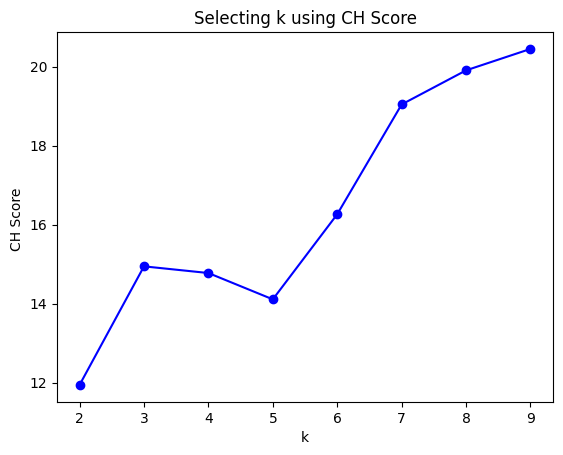

In [301]:
ch_score = []
cluster_list = list(range(2, 10))
for k in cluster_list:
    clusterer = KMeans(n_clusters=k, random_state=0)
    preds = clusterer.fit_predict(arr_data_pd_scaled)
    #centers = clusterer.cluster_centers_
    score = calinski_harabasz_score(arr_data_pd_scaled, preds)
    ch_score.append(score)

plt.plot(cluster_list, ch_score, "bo-")
plt.xlabel("k")
plt.ylabel("CH Score ")
plt.title("Selecting k using CH Score")
for x,y in zip(cluster_list, sil_score):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

Higher score is better ... not surprised as clusters not good (see PCA)

### Build model with 3 clusters

In [283]:
kmeans = KMeans(n_clusters=3, random_state=0)
optimal_model = kmeans.fit(arr_data_pd_scaled)

/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Perform PCA even though I'm not convinced it is appropriate for this data set due to interactions between metabolites.

/var/folders/wc/qp7vtgqs2h78q8fxyh4vjjb80000gn/T/ipykernel_16548/1592352294.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wc/qp7vtgqs2h78q8fxyh4vjjb80000gn/T/ipykernel_16548/1592352294.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


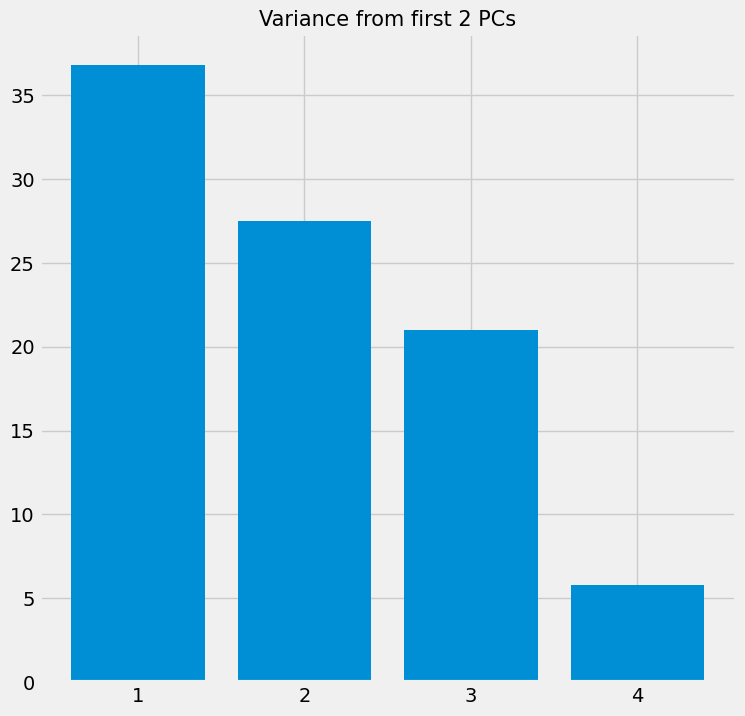

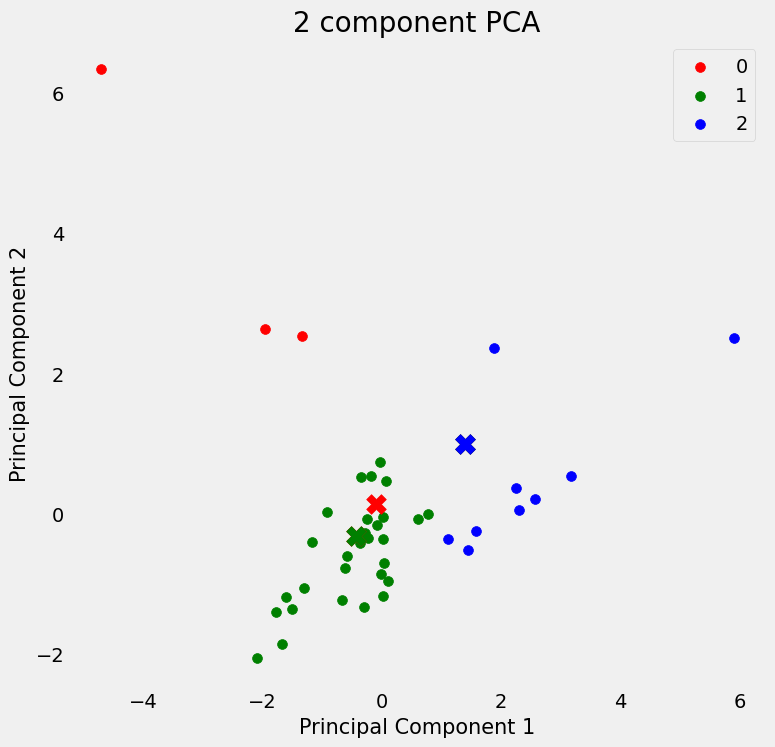

In [346]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(arr_data_pd_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
principalDf['cluster'] = kmeans.labels_
principalDf.head(5)
centroids = kmeans.cluster_centers_
labels = principalDf.cluster.unique()
fig = plt.figure(figsize=(8,8))
g = fig.add_subplot(1,1,1)
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = [str(x) for x in range(1,len(var)+1)]
g.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
g.set_title('Variance from first 2 PCs', fontsize = 15)
fig.show()
fig = plt.figure(figsize = (8,8))
g = fig.add_subplot(1,1,1) 
g.set_xlabel('Principal Component 1', fontsize = 15)
g.set_ylabel('Principal Component 2', fontsize = 15)
g.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['red', 'green', 'blue', 'yellow',]
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['cluster'] == target
    g.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
for i in range(0, len(labels)):
    g.scatter(centroids[i:,0] , centroids[i:,1] , c = colors[i], s = 200, marker="X")
g.legend(targets)
g.grid()
fig.show()

### Add cluster numbers

In [285]:
arr_data_pd['cluster'] = kmeans.labels_
arr_data_pd['metabolite'] = metabolites
arr_data_pd.head(5)

,2,3,4,5,6,7,8,9,cluster,metabolite
0,1.19,1.32,0.86,0.68,0.54,1.84,3.23,3.63,0,PYRUVATE
1,0.87,1.26,0.98,0.67,0.53,4.94,3.67,12.75,0,LACTATE
2,1.31,1.45,1.18,1.22,0.52,0.59,0.31,0.26,2,ETHANOL-AMINE
3,1.61,0.72,0.68,1.91,1.42,3.30,0.90,1.40,2,GLYCEROL
4,0.75,1.08,0.80,0.55,0.39,0.21,0.87,1.62,1,SUC


### Print out cluster contents

In [286]:
for n in range(0, 3):
    print("Cluster ", n)
    for i in range(0, arr_data_pd.shape[0]):
        if (arr_data_pd.loc[i, 'cluster'] == n):
            print(arr_data_pd.loc[i,'metabolite'])

Cluster  0
PYRUVATE
LACTATE
SUCROSE
Cluster  1
SUC
GLYCERATE
FUM
CADAVERINE
MAL
4-AMINO-BUTYRATE
CYS
2-KETOGLUTARATE
PUTRESCINE
SHIKIMATE
FRU
GLUCOSE
GLUCONATE
CPD0-1083
URATE
TREHALOSE
L-ASPARTATE
ASN
SER
GLY
L-ALPHA-ALANINE
GLT
GLN
THR
PRO
VAL
ILE
FORMATE
FOLATES
Cluster  2
ETHANOL-AMINE
GLYCEROL
CIS-ACONITATE
CIT
LYS
TYR
TRP
LEU
PHE


### Compare with kim_analysis_2007

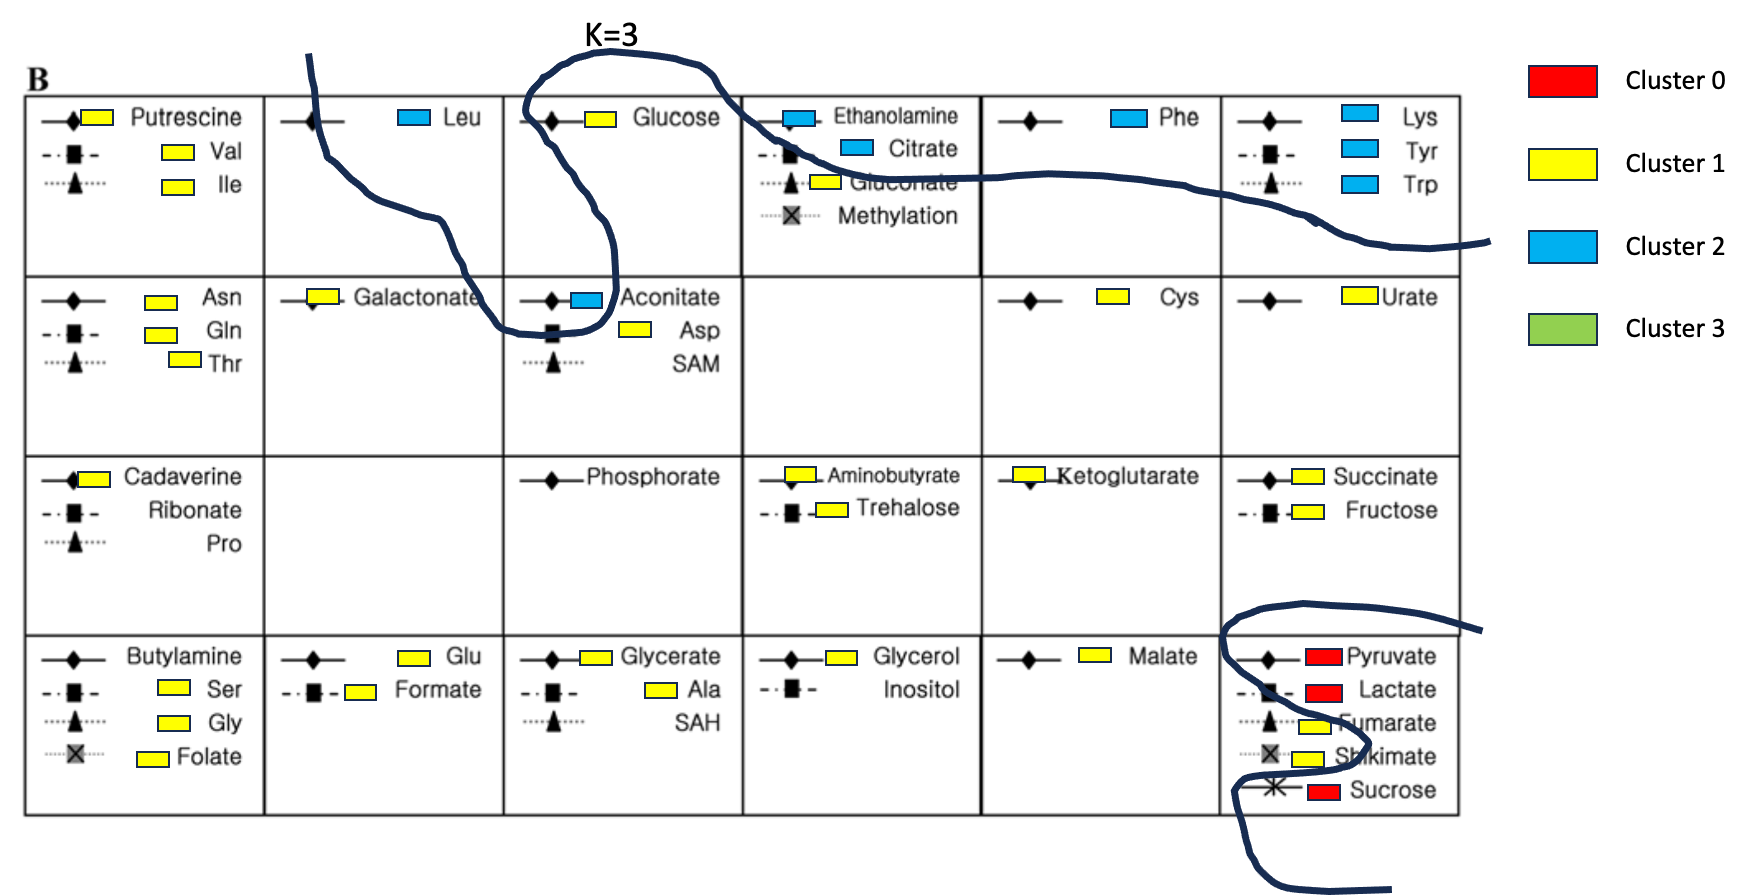

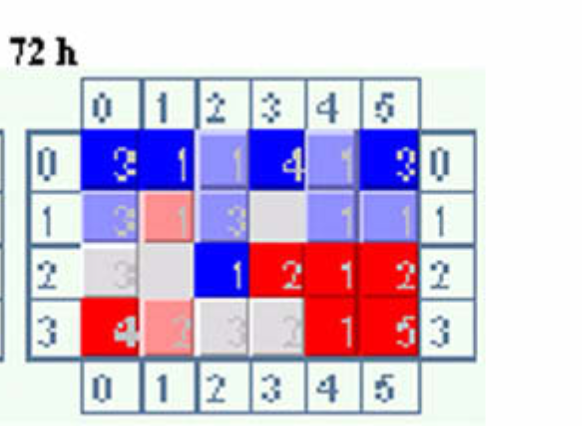

### Davies-Bouldin score

Represents the average 'similarity' of clusters

Lower value is better

Needs labelled data

In [290]:
kmeans = KMeans(n_clusters=3, random_state=0)
optimal_model = kmeans.fit(arr_data_pd_scaled)
arr_data_pd['cluster'] = kmeans.labels_
arr_data_pd['metabolite'] = metabolites
arr_data_pd.head(5)
db_score = davies_bouldin_score(arr_raw_data_pd, kmeans.labels_)
print(db_score)

1.2682481249405593


/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


As a double-check lets try applying DB score to a couple of other cluster sizes

Try K=2

In [288]:
kmeans = KMeans(n_clusters=2, random_state=0)
optimal_model = kmeans.fit(arr_data_pd_scaled)
arr_data_pd['cluster'] = kmeans.labels_
arr_data_pd['metabolite'] = metabolites
arr_data_pd.head(5)
db_score = davies_bouldin_score(arr_raw_data_pd, kmeans.labels_)
print(db_score)

1.708063641354173


/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K=2 is worse

Try K=4

In [291]:
kmeans = KMeans(n_clusters=4, random_state=0)
optimal_model = kmeans.fit(arr_data_pd_scaled)
arr_data_pd['cluster'] = kmeans.labels_
arr_data_pd['metabolite'] = metabolites
arr_data_pd.head(5)
db_score = davies_bouldin_score(arr_raw_data_pd, kmeans.labels_)
print(db_score)

1.1310109275705613


/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K=3 appears optimal

Restore data to K=3

In [293]:
kmeans = KMeans(n_clusters=3, random_state=0)
optimal_model = kmeans.fit(arr_data_pd_scaled)
arr_data_pd['cluster'] = kmeans.labels_
arr_data_pd['metabolite'] = metabolites
arr_data_pd.head(5)
db_score = davies_bouldin_score(arr_raw_data_pd, kmeans.labels_)
print(db_score)

1.2682481249405593


/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Davies Bouldin index gives us a 'structural' measure of how well the data has been clustered, but we also need a measurement of how weel the data has been biologically clustered

See milone_improving_2014 page 5 for a definition of a measure of biological connectivity

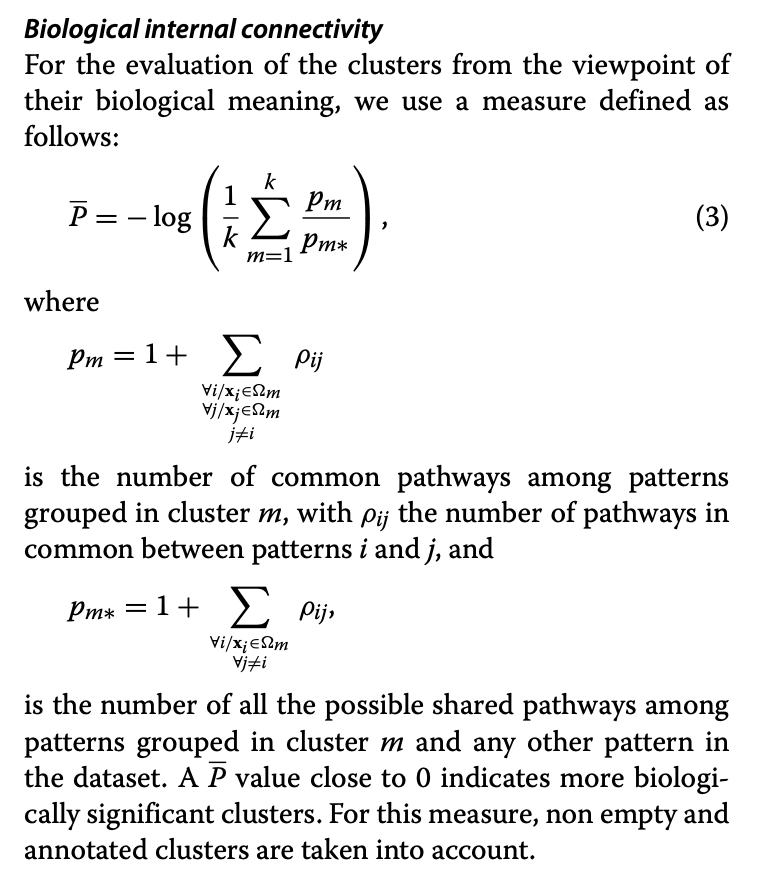

Proposing a couple of versions ... if I used pathways as part of metabolic co-clustering I'll use the formula above.

But if I used enzymes or reactions as part pof metabolic co-clustering I'll use the appropriate data to replace pathways with enzymes or reactions.

Could also try an (n-1) approach .... cluster using reactions and measure with enzymes + cluster with enzymes and measure with pathways?

Set k to equal number of clusters from previous K-means

In [294]:
k = 3

In [297]:
# Create array of empty lists
cluster_metabolites = np.empty(k, dtype=object)
for i in range(cluster_metabolites.shape[0]):
    cluster_metabolites[i] = []

# Populate each list with metabolites in that cluster
for row in range(0, arr_data_pd.shape[0]):
    clust = arr_data_pd.iloc[row]['cluster']
    cluster_metabolites[clust].append(arr_data_pd.iloc[row]['metabolite'])
for i in range(cluster_metabolites.shape[0]):
    print(i, cluster_metabolites[i])

# Read in common pathway date file
data_df = pd.read_csv("./Data/Arabidopsis-T87-timeseries-NaCl-by-metabolite-BioCyc-Master-Common-Pathways.csv")
data_df.head(5)

# Calculate intermediates
bio_con_df = pd.DataFrame(columns=['Cluster', 'pm', 'pmstar'])

for clust in range(0, k):
    for row_meta in range(0, len(cluster_metabolites[clust])):
        for col_meta in range(0, len(cluster_metabolites[clust])):
            print(clust, col_meta)
        print()
#for i in range(0, k):
#    cluster_metabolites[i].append(34)
#print(cluster_metabolites)

0 ['PYRUVATE', 'LACTATE', 'SUCROSE']
1 ['SUC', 'GLYCERATE', 'FUM', 'CADAVERINE', 'MAL', '4-AMINO-BUTYRATE', 'CYS', '2-KETOGLUTARATE', 'PUTRESCINE', 'SHIKIMATE', 'FRU', 'GLUCOSE', 'GLUCONATE', 'CPD0-1083', 'URATE', 'TREHALOSE', 'L-ASPARTATE', 'ASN', 'SER', 'GLY', 'L-ALPHA-ALANINE', 'GLT', 'GLN', 'THR', 'PRO', 'VAL', 'ILE', 'FORMATE', 'FOLATES']
2 ['ETHANOL-AMINE', 'GLYCEROL', 'CIS-ACONITATE', 'CIT', 'LYS', 'TYR', 'TRP', 'LEU', 'PHE']
0 0
0 1
0 2

0 0
0 1
0 2

0 0
0 1
0 2

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1

In [1]:
bio_con_df = pd.DataFrame(columns=['Cluster', 'pm', 'pmstar'])
for cluster in range (0, k):
    print("cluster ", cluster)
    for col_meta in range(0, len(cluster_metabolites[clust])):
        print(cluster_metabolites[clust])

NameError: name 'pd' is not defined